In [26]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Import, Clean, and Preprocess Data

In [4]:
from import_data import *
from util import *
from nltk import word_tokenize 

df = import_merge()      # create dataframe
df = clean_dataframe(df) # clean dataframe

df['speech_clean'] = df['Speech'].apply(clean_string)
df['speech_token'] = df['speech_clean'].apply(word_tokenize)
df['speech_wo_sw'] = df['speech_token'].apply(remove_stopwords)
df['speech_lemma'] = df['speech_wo_sw'].apply(normalize_string)
df['lemma_text'] = df['speech_lemma'].apply(lambda w: ' '.join(w)) # join lemma tokens into str


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	933 values cleaned (11.0%)
	37 values unable to be parsed (0.44%), set to NaN
Result contains 8444 (99.56%) values in the correct format and 37 null values (0.44%)


# Analyze Word Usage

**Wordclouds from TF-IDF F"requencies**

In [17]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# condence speeches by hdi_class
normalized='lemma_text'
col_names = ['Low','Medium','High','Very High']
corpus = [' '.join(df.query(f"hdi_class=='{col}'")[normalized]) for col in col_names] # 1 cum. speech per class

# apply vectorizer to speech texts
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus) # generate sparse matrix
feature_names = vectorizer.get_feature_names() # list of words


# create dense matrix -- rearrange to create DF containing words-TFIDF
dense = X.todense()
denselist = dense.tolist()
tfidf_mat = pd.DataFrame(denselist, columns=feature_names) # col=words
data = tfidf_mat.transpose() # want column to represent HDI class
data.columns = col_names # defined when condensed speeches


# generate word clouds from TF-IDF frequencies
max_words = 30 # only display n words per cloud
wordclouds = [ WordCloud(collocations=False,
                         background_color='white',
                         max_words=max_words, 
                         width=400,
                         height=400).generate_from_frequencies(data[col]) for col in col_names ]



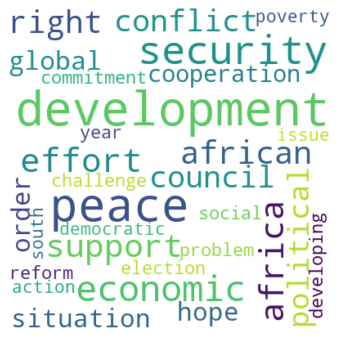

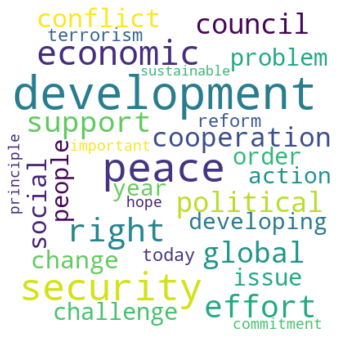

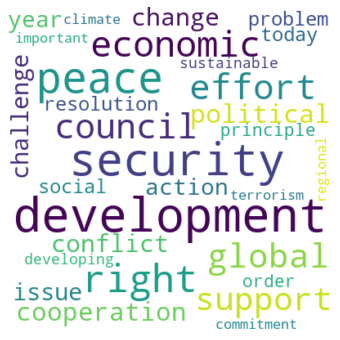

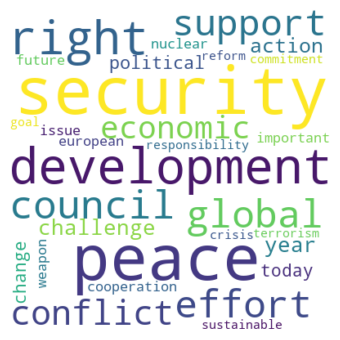

In [19]:
# plot wordclouds for each class
for i in range(len(col_names)):
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(wordclouds[i], interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"wordcloud_{col_names[i].lower().replace(' ','')}.png",
                dpi=1200, transparent=False)
    

**Cosign Similarity of Speeches Between HDI Classes**

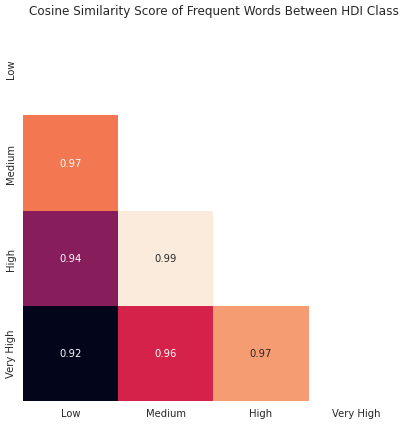

In [124]:
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# calculate cosine similarity between class vectors
vectorizer = TfidfVectorizer(stop_words='english').fit_transform(corpus) # generate sparse matrix().fit_transform(corpus)
vectors=vectorizer.toarray()
csim = cosine_similarity(vectors)

# create heatmap with cosine similarity values between classes
mask = np.zeros_like(csim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(csim, 
                     mask=mask, 
                     square=True, 
                     annot=True, 
                     cbar=False,
                     xticklabels=col_names, 
                     yticklabels=col_names)
    ax.set_title('Cosine Similarity Matrix Between HDI Classes')
    plt.savefig(f"cosign_similarity.png",dpi=1200, transparent=False)
    

# Sentiment Analysis

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# calculate polarity of speech (range:-1,1)
vader = SentimentIntensityAnalyzer()
get_compound = lambda s: vader.polarity_scores(s).get('compound')
df['speech_polarity'] = df['lemma_text'].apply(get_compound)
df['is_negative'] = np.where( df['speech_polarity']<-0.05, 1, 0 ) #positive>0.05, negative<-0.05

# summarize classes
df_neg = df.groupby('hdi_class').agg(pol_mean=('speech_polarity','mean'),
                                     pol_sd=('speech_polarity','std'),
                                     pol_max=('speech_polarity','max'),
                                     pol_min=('speech_polarity','min'),                                     
                                     n_neg=('is_negative','sum'),
                                     n_speech=('is_negative','size'),
                                     perc_neg=('is_negative','mean')).reset_index()
df_neg


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonathanharris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,hdi_class,pol_mean,pol_sd,pol_max,pol_min,n_neg,n_speech,perc_neg
0,High,0.872097,0.464588,0.9999,-0.9997,77,1202,0.064060
1,Low,0.955080,0.274778,1.0000,-0.9998,27,1326,0.020362
2,Medium,0.907577,0.405932,1.0000,-0.9998,57,1273,0.044776
3,Very High,0.873982,0.463566,1.0000,-0.9997,72,1173,0.061381


In [ ]:
# scatter plot of Sentiment scores
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(data=df, x='hdi_score', y='speech_polarity', hue='hdi_class')
ax.set_title('Speech Polarity vs HDI Score')
ax.set_ylabel('Speech Polarity')
ax.set_xlabel('HDI Score')

handles, labels  =  ax.get_legend_handles_labels()
handles[1],handles[3] = handles[3],handles[1]
handles[0],handles[3] = handles[3],handles[0]
ax.legend(handles, ['Low', 'Medium', 'High','Very High'], loc='best')
# plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.savefig(f"polarity_hdi.png",dpi=1200, transparent=False)



# Source-Target Class References

**Parse speeches and identify countries referenced**

In [110]:
from geotext import GeoText
from dataprep.clean import clean_country

# create dataframe tracking mentions of other countries
df_mentions = pd.DataFrame() # store all mentions
cols = ['Year','Country or Area','country_cleaned','hdi_class'] # columns of interest

for i in range(df.shape[0]):
    targets = GeoText(df['Speech'][i]).countries # [] of countries mentioned

    if targets!=[]:
        row = pd.DataFrame(df[cols].loc[i]).T # create DF of row i
        row = row.reindex( row.index.repeat(len(targets)) ) # repeat by n_targets
        row.columns = ['year','source','source_clean','source_class']
        row['target'] = targets # add targets columns
        df_mentions = pd.concat([df_mentions, row]) # concat with df_mentions

    
# remove self-mentions -- when country refers to itself 
df_mentions = clean_country(df_mentions,
                            'target',
                            output_format='name') # clean target to compare to source_clean 

bool_mask = list(df_mentions['source_clean']!=df_mentions['target_clean']) # target != source
df_mentions = df_mentions[bool_mask].sort_values(['year','source_clean'])\
                                    .reset_index(drop=True) # remove self-mentions


# determine target hdi_class if possible
def retrieve_class(year, country):
    try:
        country='\"'+country+'\"'
        query_str = f"Year=={year} and country_cleaned=={country}"
        val = df.query(query_str)['hdi_class'].values[0]
    except:
        val=np.nan
    return val

df_mentions['target_class'] = df_mentions.apply(lambda x: retrieve_class(x['year'],x['target_clean']), axis=1)


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	3852 values cleaned (1.55%)
Result contains 248165 (100.0%) values in the correct format and 0 null values (0.0%)


**Sankey Diagram of HDI Source-Target Mentions**

In [121]:
import plotly.graph_objects as go

# group data by connections (source-target) and determine count
df_men_group = df_mentions.dropna(subset=['source_class','target_class'])\
                          .groupby(['source_class','target_class'])\
                          .size()\
                          .reset_index()\
                          .rename(columns={0:'n'})


# create unique source and class labels
nom_dict = {'Low':0,'Medium':1,'High':2,'Very High':3} # rename
df_men_group['source_class_label'] = df_men_group['source_class'].replace(nom_dict)
df_men_group['target_class_label'] = df_men_group['target_class'].replace(nom_dict)+4
df_men_group.sort_values(by=['source_class_label','target_class_label'], ascending=True, inplace=True)


# create sankey plot
color = ['rgba(0,124,176,.8)', 
         'rgba(0, 179, 98,.8)', 
         'rgba(9, 0, 179,.8)', 
         'rgba(179, 54, 0,.8)']
fig = go.Figure(data=[go.Sankey(
    node = dict(pad = 15,
                thickness = 20,
                line = dict(color = "black", width = 0.5),
                label = ['Low','Medium','High','Very High',
                         'Low','Medium','High','Very High'],
                color = ['rgba(0,124,176,.8)',
                         'rgba(0, 179, 98,.8)',
                         'rgba(9, 0, 179,.8)',
                         'rgba(179, 54, 0,.8)']*2
               ),
    link = dict(source = df_men_group['source_class_label'],
                target = df_men_group['target_class_label'],
                value = df_men_group['n'],
                color = ['rgba(0,124,176,.3)','rgba(0,124,176,.3)','rgba(0,124,176,.3)','rgba(0,124,176,.3)',
                         'rgba(0, 179, 98,.3)','rgba(0, 179, 98,.3)','rgba(0, 179, 98,.3)','rgba(0, 179, 98,.3)',
                         'rgba(9, 0, 179,.3)','rgba(9, 0, 179,.3)','rgba(9, 0, 179,.3)','rgba(9, 0, 179,.3)',
                         'rgba(179, 54, 0,.3)','rgba(179, 54, 0,.3)','rgba(179, 54, 0,.3)','rgba(179, 54, 0,.3)']))])

fig.update_layout(title_text="Number of Times Source Class Referenced Target Class", 
                  font_size=10,
                  width=800,
                  height=600)
fig.show()  